In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/frames_errors.csv", header=None)
df.columns = [
    "block_id",
    "frame_idx",
    "E_mu_Z",
    "E_mu_phys_est",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
    "nTot",
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
    "synErr",
    "N_EC_rounds",
    "maintenance_flag",
    "estimator_name",
    "f_EC",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

In [3]:
df = df.dropna(subset=["f_EC"])

In [4]:
id_features = [
    "block_id",
    "frame_idx",
]

phys_gt_features = [
    "E_mu_Z",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
]

phys_features = [
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
]

est_features = [
    # "E_mu_phys_est",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

proxy_features = [
    "N_EC_rounds",
    "f_EC",
]

df = df[id_features + phys_gt_features + phys_features + est_features + proxy_features]

In [5]:
def calculate_score(df, weight_f_ec=1.0, weight_rounds=1.0, rounds_power=1.0):
    df = df.copy()
    max_rounds = df["N_EC_rounds"].max()
    rounds_norm = df["N_EC_rounds"] / max_rounds
    penalty_f_ec = (df["f_EC"] - 1) * weight_f_ec
    penalty_rounds = (rounds_norm**rounds_power) * weight_rounds
    penalty_score = penalty_f_ec + penalty_rounds
    df["score"] = 100 / (1 + penalty_score)
    df["score"] = df["score"] - df["score"].mean()
    return df

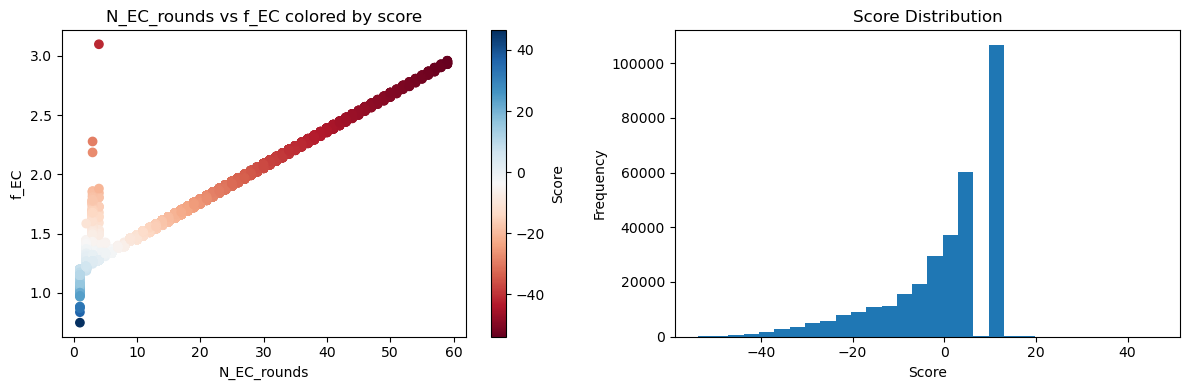

In [6]:
weight_f_ec = 0.8
weight_rounds = 1.5
rounds_power = 1.5
df = calculate_score(df, weight_f_ec, weight_rounds, rounds_power)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(df["N_EC_rounds"], df["f_EC"], c=df["score"], cmap="RdBu")
plt.colorbar(label="Score")
plt.xlabel("N_EC_rounds")
plt.ylabel("f_EC")
plt.title("N_EC_rounds vs f_EC colored by score")

plt.subplot(1, 2, 2)
df["score"].hist(bins=30, grid=False)
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
model_simulation = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    loss_function="RMSE",
    verbose=100,
    random_state=42,
)

In [8]:
simulation_input_features = phys_gt_features + phys_features + est_features
simulation_target = "score"

In [9]:
X_train_sim, X_val_sim, y_train_sim, y_val_sim = train_test_split(
    df[simulation_input_features], df[simulation_target], test_size=0.2, random_state=42
)

In [10]:
simulation_input_scaler_X = StandardScaler()
X_train_sim_scaled = simulation_input_scaler_X.fit_transform(X_train_sim)
X_val_sim_scaled = simulation_input_scaler_X.transform(X_val_sim)

In [11]:
model_simulation.fit(X_train_sim_scaled, y_train_sim, eval_set=(X_val_sim_scaled, y_val_sim))

0:	learn: 11.7433684	test: 11.6837041	best: 11.6837041 (0)	total: 61.2ms	remaining: 2m 2s
100:	learn: 2.6556818	test: 2.6607598	best: 2.6607598 (100)	total: 869ms	remaining: 16.3s
200:	learn: 2.1687044	test: 2.1891389	best: 2.1891389 (200)	total: 1.68s	remaining: 15.1s
300:	learn: 2.0608139	test: 2.0876555	best: 2.0876555 (300)	total: 2.4s	remaining: 13.5s
400:	learn: 2.0197063	test: 2.0495275	best: 2.0495127 (399)	total: 3.17s	remaining: 12.6s
500:	learn: 1.9917884	test: 2.0246791	best: 2.0246791 (500)	total: 3.93s	remaining: 11.8s
600:	learn: 1.9766130	test: 2.0134202	best: 2.0134202 (600)	total: 4.83s	remaining: 11.2s
700:	learn: 1.9650347	test: 2.0062268	best: 2.0062268 (700)	total: 5.57s	remaining: 10.3s
800:	learn: 1.9560027	test: 2.0028627	best: 2.0028627 (800)	total: 6.39s	remaining: 9.56s
900:	learn: 1.9488735	test: 2.0003644	best: 2.0003644 (900)	total: 7.31s	remaining: 8.92s
1000:	learn: 1.9425175	test: 1.9979821	best: 1.9979821 (1000)	total: 8.26s	remaining: 8.25s
1100:	lea

In [12]:
y_pred = model_simulation.predict(X_val_sim_scaled)
mae = mean_absolute_error(y_val_sim, y_pred)
mse = mean_squared_error(y_val_sim, y_pred)
rmse = root_mean_squared_error(y_val_sim, y_pred)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 1.3976709467667725, MSE: 3.9738956284191724, RMSE: 1.9934632247471165


In [13]:
def create_lag_features(df, features_to_lag, lags):
    lagged_features = []
    df = df.copy()
    for lag in range(1, lags + 1):
        for feature in features_to_lag:
            df[f"{feature}_lag{lag}"] = df.groupby("block_id")[feature].shift(lag)
            lagged_features.append(f"{feature}_lag{lag}")
    df = df.fillna(0)
    return df, lagged_features

In [ ]:
features_to_lag = phys_features + phys_gt_features + est_features

df_lagged, lagged_features = create_lag_features(df, features_to_lag, 20)

In [15]:
# Test (Val)
start_idx = df_lagged[(df_lagged["block_id"] == 1489460492) & (df_lagged["frame_idx"] == 99)].index[
    0
]
end_idx = df_lagged[(df_lagged["block_id"] == 1840064900) & (df_lagged["frame_idx"] == 101)].index[
    0
]

test_df = df_lagged.loc[start_idx:end_idx].copy()
assert len(test_df) == 2000, "Test (Val) set size is not 2000 rows"

# Train
all_block_ids = df_lagged["block_id"].unique()
train_blocks = [bid for bid in all_block_ids if bid not in test_df["block_id"].values]
train_df = df_lagged[df_lagged["block_id"].isin(train_blocks)]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 326090
Test: 2000


In [16]:
# Вход для первой модели (E)
policy_E_input_features = phys_features + lagged_features

# Вход для второй модели (R)
policy_R_input_features = policy_E_input_features + ["E_mu_Z_est"]

# Вход для третьей модели (s)
policy_s_input_features = policy_R_input_features + ["R"]

In [18]:
policy_model_E = CatBoostRegressor(
    iterations=50, learning_rate=0.1, depth=6, loss_function="RMSE", verbose=0, random_state=42
)
policy_model_R = CatBoostClassifier(
    iterations=50,
    learning_rate=0.1,
    depth=6,
    loss_function="MultiClass",
    verbose=0,
    random_state=42,
)
policy_model_s = CatBoostRegressor(
    iterations=50, learning_rate=0.1, depth=6, loss_function="RMSE", verbose=0, random_state=42
)

le_R_policy = LabelEncoder()
le_R_policy.fit(df["R"])

LabelEncoder()

In [29]:
# --- Гиперпараметры для CEM ---
N_EPOCHS = 20  # Количество итераций обучения
BATCH_SIZE = 2048  # Количество состояний, которые мы рассматриваем в одной эпохе
N_SESSIONS = 100  # Количество наборов действий, генерируемых для каждого состояния
PERCENTILE = 75  # Процентиль для отбора "элитных" действий
SMOOTHING = 0.7  # Коэффициент сглаживания для обновления политики

print("--- Начало обучения Каскадной Политики методом Cross-Entropy ---")

for epoch in range(N_EPOCHS):
    # 1. Выбираем батч состояний из обучающего датасета
    states_batch = train_df.sample(n=BATCH_SIZE, random_state=epoch)

    # Расширяем состояния, чтобы сгенерировать N_SESSIONS действий для каждого
    total_samples = BATCH_SIZE * N_SESSIONS
    expanded_states = states_batch.loc[states_batch.index.repeat(N_SESSIONS)].reset_index(drop=True)

    # 2. ГЕНЕРАЦИЯ ДЕЙСТВИЙ (SESSIONS)
    # На первых эпохах или случайно - действуем полностью случайно (exploration)
    # В остальных случаях - используем текущую политику с добавлением шума (exploitation + exploration)

    # Действие 1: Выбор E_mu_Z_est
    X_E_states = expanded_states[policy_E_input_features]
    if epoch < 2:  # Warm-up с чисто случайными действиями
        actions_E = expanded_states["E_mu_Z_est"].values * np.random.uniform(
            0.9, 1.1, size=total_samples
        )
    else:
        pred_E = policy_model_E.predict(X_E_states)
        noise = np.random.normal(0, 0.05, size=total_samples) * expanded_states["E_mu_Z_est"].values
        actions_E = pred_E + noise

    # Действие 2: Выбор R
    X_R_states = X_E_states.copy()
    X_R_states["E_mu_Z_est"] = actions_E
    if epoch < 2:
        actions_R_labels = np.random.choice(
            le_R_policy.transform(le_R_policy.classes_), size=total_samples
        )
    else:
        # predict_proba дает больше разнообразия для исследования
        action_probs = policy_model_R.predict_proba(X_R_states)
        actions_R_labels = np.array([np.random.choice(len(p), p=p) for p in action_probs])
    actions_R_values = le_R_policy.inverse_transform(actions_R_labels)

    # Действие 3: Выбор s
    X_s_states = X_R_states.copy()
    X_s_states["R"] = actions_R_values
    if epoch < 2:
        actions_s = np.random.choice(train_df["s"].unique(), size=total_samples)
    else:
        pred_s = policy_model_s.predict(X_s_states)
        noise = np.random.normal(0, 50, size=total_samples)
        actions_s = np.round(pred_s + noise).astype(int)

    # 3. ОЦЕНКА ДЕЙСТВИЙ СИМУЛЯТОРОМ
    expanded_states["E_mu_Z_est"] = actions_E
    expanded_states["R"] = actions_R_values
    expanded_states["s"] = actions_s
    expanded_states["p"] = 4800 - actions_s

    sim_X = expanded_states[simulation_input_features]
    sim_X_scaled = simulation_input_scaler_X.transform(sim_X)
    rewards = model_simulation.predict(sim_X_scaled)

    # 4. ОТБОР ЭЛИТНЫХ ДЕЙСТВИЙ
    reward_threshold = np.percentile(rewards, PERCENTILE)
    elite_mask = rewards >= reward_threshold

    if not np.any(elite_mask):
        print(f"Эпоха {epoch + 1}/{N_EPOCHS}: Не найдено элитных сессий. Пропуск.")
        continue

    # Выбираем состояния и действия, которые привели к высокой награде
    elite_E_states = X_E_states[elite_mask]
    elite_R_states = X_R_states[elite_mask]
    elite_s_states = X_s_states[elite_mask]

    elite_actions_E = actions_E[elite_mask]
    elite_actions_R = actions_R_labels[elite_mask]
    elite_actions_s = actions_s[elite_mask]

    # 5. ОБУЧЕНИЕ ПОЛИТИКИ НА ЭЛИТНЫХ ДЕЙСТВИЯХ
    # Используем fit для постепенного дообучения моделей
    policy_model_E.fit(elite_E_states, elite_actions_E)
    policy_model_R.fit(elite_R_states, elite_actions_R)
    policy_model_s.fit(elite_s_states, elite_actions_s)

    mean_reward = np.mean(rewards)
    elite_reward = np.mean(rewards[elite_mask])
    print(
        f"Эпоха {epoch + 1}/{N_EPOCHS}: Средняя награда: {mean_reward:.4f}, Элитная награда: {elite_reward:.4f}"
    )

print("\n--- Обучение Каскадной Политики методом Cross-Entropy завершено! ---")

--- Начало обучения Каскадной Политики методом Cross-Entropy ---
Эпоха 1/20: Средняя награда: -1.8551, Элитная награда: 9.7946
Эпоха 2/20: Средняя награда: -1.5857, Элитная награда: 9.8733


KeyboardInterrupt: 

--- Генерация предсказаний на тестовом наборе ---
Предсказанные действия:
        E_mu_Z_est_pred  R_pred  s_pred  p_pred
285999         0.028009     0.7    3572    1228
286000         0.028222     0.7    3557    1243
286001         0.026206     0.7    3489    1311
286002         0.026069     0.7    3477    1323
286003         0.025791     0.7    3468    1332

--- Оценка сгенерированных действий симулятором ---
Средний 'score' в оригинальном test_df: 1.6405
Средний 'score' для действий, сгенерированных политикой: 10.8647


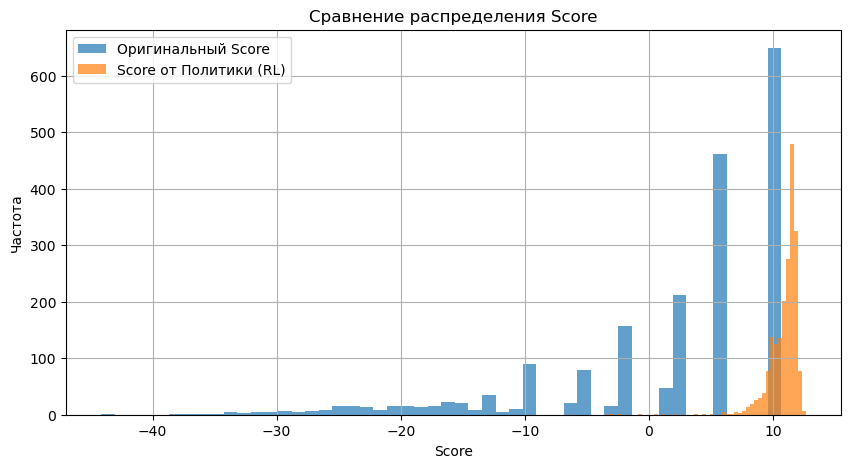

In [20]:
print("--- Генерация предсказаний на тестовом наборе ---")

# Создаем копию тестового датафрейма для предсказаний
test_df_pred = test_df.copy()

# 1. Предсказание E_mu_Z_est
X_test_E = test_df_pred[policy_E_input_features]
pred_E = policy_model_E.predict(X_test_E)
test_df_pred["E_mu_Z_est_pred"] = pred_E

# 2. Предсказание R
# Создаем входные данные, заменяя оригинальное значение E_mu_Z_est на предсказанное
X_test_R = test_df_pred[policy_E_input_features].copy()
X_test_R["E_mu_Z_est"] = pred_E
pred_R_labels = policy_model_R.predict(X_test_R)
# Преобразуем метки классов обратно в исходные значения
pred_R_values = le_R_policy.inverse_transform(pred_R_labels.astype(int).flatten())
test_df_pred["R_pred"] = pred_R_values

# 3. Предсказание s
# Создаем входные данные, добавляя предсказанные E_mu_Z_est и R
X_test_s = X_test_R.copy()
X_test_s["R"] = pred_R_values
pred_s = policy_model_s.predict(X_test_s)
test_df_pred["s_pred"] = np.round(pred_s).astype(int)

# 4. Вычисление p
test_df_pred["p_pred"] = 4800 - test_df_pred["s_pred"]

print("Предсказанные действия:")
print(test_df_pred[["E_mu_Z_est_pred", "R_pred", "s_pred", "p_pred"]].head())


# 5. Оценка предсказанных действий с помощью симулятора
print("\n--- Оценка сгенерированных действий симулятором ---")

# Подготавливаем данные для симулятора, используя предсказанные действия
sim_X_test = test_df[simulation_input_features].copy()
sim_X_test["E_mu_Z_est"] = test_df_pred["E_mu_Z_est_pred"]
sim_X_test["R"] = test_df_pred["R_pred"]
sim_X_test["s"] = test_df_pred["s_pred"]
sim_X_test["p"] = test_df_pred["p_pred"]

# Масштабируем данные и делаем предсказание
sim_X_test_scaled = simulation_input_scaler_X.transform(sim_X_test)
predicted_scores = model_simulation.predict(sim_X_test_scaled)

# Сравниваем средний score
original_mean_score = test_df["score"].mean()
policy_mean_score = np.mean(predicted_scores)

print(f"Средний 'score' в оригинальном test_df: {original_mean_score:.4f}")
print(f"Средний 'score' для действий, сгенерированных политикой: {policy_mean_score:.4f}")

# Визуализация
plt.figure(figsize=(10, 5))
plt.hist(test_df["score"], bins=50, alpha=0.7, label="Оригинальный Score")
plt.hist(predicted_scores, bins=50, alpha=0.7, label="Score от Политики (RL)")
plt.title("Сравнение распределения Score")
plt.xlabel("Score")
plt.ylabel("Частота")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_df[["E_mu_Z", "R", "s", "p"]].to_csv("submission.csv", header=False, index=False)

In [ ]:
def evaluate_submission(
    submission_path, test_df, model, scaler, sim_features, original_est_features
):
    """
    Оценивает submission-файл, сравнивая его score с оригинальным.

    Args:
        submission_path (str): Путь к csv файлу с предсказаниями.
        test_df (pd.DataFrame): Оригинальный тестовый датафрейм.
        model (CatBoostRegressor): Обученная модель-симулятор.
        scaler (StandardScaler): Обученный скейлер для входов симулятора.
        sim_features (list): Список фичей для входа в симулятор.
        original_est_features (list): Список колонок-действий (E, R, s, p).
    """
    # 1. Выводим оригинальный score
    original_mean_score = test_df["score"].mean()
    print(f"Средний 'score' в оригинальном test_df: {original_mean_score:.4f}")

    # 2. Загружаем submission файл
    submission_df = pd.read_csv(submission_path, header=None)
    submission_df.columns = original_est_features

    # 3. Подставляем значения из submission в копию тестового датафрейма
    sim_X_sub = test_df[sim_features].copy()

    # Важно: Убедимся, что индексы совпадают для корректного присваивания
    sim_X_sub.reset_index(drop=True, inplace=True)
    submission_df.reset_index(drop=True, inplace=True)

    for col in original_est_features:
        if col in sim_X_sub.columns:
            sim_X_sub[col] = submission_df[col]

    # 4. Оцениваем score с помощью симулятора
    sim_X_sub_scaled = scaler.transform(sim_X_sub)
    submission_scores = model.predict(sim_X_sub_scaled)
    submission_mean_score = np.mean(submission_scores)

    print(f"Средний 'score' для действий из файла '{submission_path}': {submission_mean_score:.4f}")
    return original_mean_score, submission_mean_score


# Вызываем функцию для оценки вашего файла
# Используем `est_features`, так как именно эти колонки мы заменяем
evaluate_submission(
    "../catboost_2/submission.csv",
    test_df,
    model_simulation,
    simulation_input_scaler_X,
    simulation_input_features,
    est_features,
)

Средний 'score' в оригинальном test_df: 1.6405
Средний 'score' для действий из файла '../catboost_2/submission.csv': 1.5989


(1.6404570989432468, 1.598926900849186)